During the Fall semester of 2017, [CSU, Chico](http://www.csuchico.edu/)'s [Dr. Ann Bykerk-Kauffman](http://www.csuchico.edu/%7eabykerk-kauffman/) gave one of three talks at the [Department of Geological and Environmental Sciences](http://www.csuchico.edu/geos/index.shtml) seminar titled [2017 Hurricane Talk](http://www.csuchico.edu/geos/stories/17.09.14_HurricaneTalk.shtml).  Part of Dr. Bykerk-Kauffman's presentation included data from the National Hurricane Center's (NHC) Data Archive: https://www.nhc.noaa.gov/data/#hurdat.  After her talk, Dr. David M. Hassenzahl, Dean of the [College of Natural Sciences](https://www.csuchico.edu/nsci/index.shtml), asked a great question, which I'll try to paraphrase:  is the variation in the (empirical) storm season changing over time?  This blog post seeks to answer that question and then slightly expand on the idea.

The HURDAT2 data used here was slightly processed from the NHC data archive.  Specifically, storms from both the Pacific and Atlantic oceans were combined.

Throughout, we'll use [Python 3](https://www.python.org/) and various packages common to Python's datascience community.  The source code and data are available on [GitHub](https://github.com/roualdes/stormevents/).

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import bplot as bp
import datetime
import pystan
import stan_utility
import requests
%matplotlib inline

/Users/ez/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The slightly processed (for this analysis) data are also hosted on GitHub.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/roualdes/stormevents/master/data.csv')

To properly work with dates in Python, we convert dates, in the format YYYMMDD, into formal datestime objects.

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.drop_duplicates('name', inplace=True) # don't double count storms
df = df.loc[df.date > pd.to_datetime('1915'), :].copy() # do we really only want > 1915
df['year'] = df.date.dt.year                                                         
#df['day'] = df.date.dt.day                                                           
df['cnum_dates'] = mdates.date2num([datetime.datetime(2018, d.month, d.day)                     
                         for _, d in df['date'].dropna().iteritems()]) 
df['num_dates'] = mdates.date2num([datetime.datetime(d.year, d.month, d.day)                     
                         for _, d in df['date'].iteritems()])


With dates properly set up, we can easily count the total number storms that hit either the Pacific or Atlantic oceans by month since 1915.  During the 20th century, September was the most common month for a storm.

In [4]:
df['date'].dt.month.value_counts().sort_index()

1       5
2       1
3       1
4       5
5      71
6     220
7     379
8     582
9     679
10    369
11     96
12     14
Name: date, dtype: int64

The same information is displayed with a density plot.  What's a bit better about this display is that we can see how well the official storm season captures the highest density of storms.  Note that the plot below is aggregated over all the years for which we have data.

In [4]:
storm_season = mdates.date2num([datetime.datetime(2018, 6, 1), 
                                datetime.datetime(2018, 10, 30)])
storm_season

array([736846., 736997.])

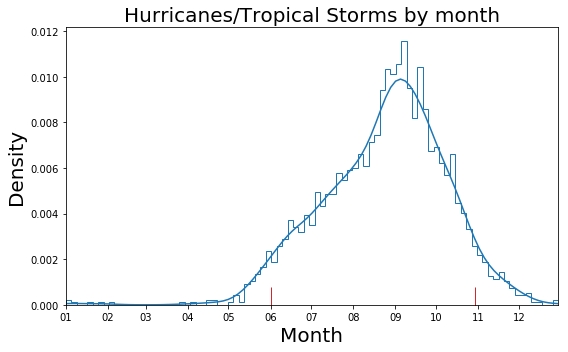

In [5]:

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.density(df['cnum_dates'])       
bp.histogram(df['cnum_dates'], bins=365//4)
bp.rug(storm_season, markersize=36, color='tab:red')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Density', fontsize=20)      
plt.title('Hurricanes/Tropical Storms by month', fontsize=20)
ax.set_xlim([df['cnum_dates'].min(), df['cnum_dates'].max()])  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())                                 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))                          
plt.tight_layout()

The next step defines, for the purpose of this analysis, the empirical variation in the storm season.  To measure variation we will use the [median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD) statistic.  The MAD statistic is an estimator of the population standard deviation σ, which is based on a median instead of the mean making it more robust to potential outliers.  

To measure the variation of the emprical storm season over time, first consider a year $Y$.  In year $Y$, there will be a handful of storms that occur at different times.  We define the median storm date by treating each day within the year as a number.  Technically, dates are given numbers relative to 0001-01-01 UTC plus 1; see [matplotlib dates](https://matplotlib.org/api/dates_api.html) for more details.  For the most part, yearly median storm dates fall in August or September.

In [6]:
df['median'] = df.groupby('year')['num_dates'].transform(lambda x: x.median())
df['median_date'] = mdates.num2date(df['median'])
df['median_date'].dt.month.value_counts().sort_index()

8    1703
9     719
Name: median_date, dtype: int64

The median storm date strictly measures an average storm date within each year $Y$. Variation on the other hand measures average distance from the average.  Here, we measure distance from the median storm date in days.  Since, some storms will occur before the median storm date and some storms after, we take the absolute value of the distance of each storm from the median storm date. Our MAD estimator is the median of the absolute values of these distances.  The last step scales our MAD estimator by $\frac{1}{\Phi^{-1}(0.75)} \approx 1.4826$, in a fairly standard assumption of normal data.  In the end, we have MAD estimates of the variation in the empirical storm season for each year in our data set.

In [7]:
df['mad'] = df.apply(lambda x: np.abs((x['num_dates'] - x['median'])), axis=1)
sdf = (df[['year', 'mad']].groupby('year', as_index=False)
            .aggregate(lambda x: 1.4826*np.median(x)))


A plot of the MAD estimators across time appears to show a subtle positive slope.

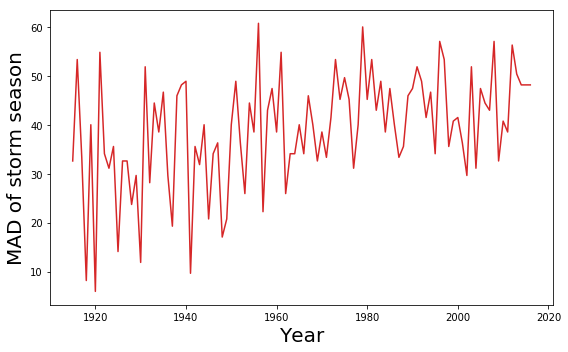

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'], color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('MAD of storm season', fontsize=20)
plt.tight_layout()

Fitting ordinary least squares to these data ignores any correlation is storm seasons across time.  Treating each year as independent is suspicious and can lead to over confident conclusions.

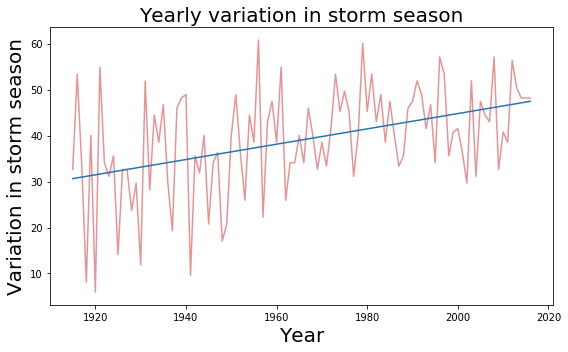

In [6]:
reg = sm.OLS(sdf['mad'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'], color='tab:red', alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [32]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    mad   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     22.61
Date:                Thu, 07 Jun 2018   Prob (F-statistic):           6.69e-06
Time:                        12:04:31   Log-Likelihood:                -422.89
No. Observations:                 102   AIC:                             849.8
Df Residuals:                     100   BIC:                             855.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -427.3097    102.060     -4.187      0.0

The regression output suggests that the variation in empirical storm season is increasing over time.  As stated before, I'm hesitant to admit that the storm season this year is not related to the storm season of next year in any way.  To better model such a correlation acorss time, we will fit a Bayesian structural time series model using [Stan](http://mc-stan.org/).  The model is local linear trend model

$$ y_t = \mu_t + \epsilon_t \\
\mu_{t+1} = \mu_t + \nu_t + \gamma_t \\
\nu_{t+1} = \nu_t + \xi_t $$

where $\epsilon_t \sim \mathbb{N}(0, \sigma_{\epsilon}^2)$, $\gamma_t \sim \mathbb{N}(0, \sigma_{\gamma}^2)$, and $\xi_t \sim \mathbb{N}(0, \sigma_{\xi}^2)$ are independent.  The interested reader should consult [Time Series Analysis by State Space Methods](https://www.amazon.com/Time-Analysis-State-Space-Methods/dp/019964117X/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=BXZQ1XM11ZFFZDP4QVSP) for more details on the model.  

For our purposes, this model interests us because it will account for the correlation in storm seasons across time and provides us with a parameter that models the slope over time, namely $\nu_t$.  To see why $\nu_t$ is can be interpreted as a slope, consider the expected value of the change in the variable $y$ from time $t+1$ to $t$

$$ \mathbb{E}(y_{t+1} - y_t) = \mu_{t+1} - \mu_t = \mu_t + \nu_t - \mu_t = \nu_t$$

The above equation indicates that for every one unit increase in time, $y$ will change by $\nu$.  The most difficult part of this is accepting that we allow the slope to vary by time.

In Stan, we write this local linear trend model as follows.

In [13]:
#local_linear = requests.get('https://raw.githubusercontent.com/roualdes/stormevents/master/local_linear.stan').text
with open('/Users/ez/stormevents/local_linear.stan', 'r') as ll:
    local_linear = ll.read()
print(local_linear)

data {
  int <lower=1> T;
  vector[T] y;
}
transformed data {
  real sd_y = sd(y);
}
parameters {
  vector[T] u_err;
  real<lower=0> u_tau;
  vector[T] v_err;
  real<lower=0> v_tau;
  real<lower=0> y_err;
}
transformed parameters {
  vector[T] u;
  vector[T] v;

  u[1] = y[1] + u_tau * u_err[1];
  v[1] = v_tau * v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + u_tau * u_err[t-1];
    v[t] = v[t-1] + v_err[t-1];
  }
}
model {
  // priors
  v_err ~ normal(0, 1);
  v_tau ~ gamma(2, 1);
  u_err ~ normal(0, 1);
  u_tau ~ gamma(2, .1);
  y_err ~ exponential(1 / sd_y);

  // likelihood
  y ~ normal(u, y_err);
}
generated quantities {
  vector[T] y_pred;
  for (t in 1:T)
    y_pred[t] = normal_rng(u[t], y_err);
}



In order to fit this model to the yearly variation in the storm season, we need to compile the above Stan program.

In [14]:
stmod = pystan.StanModel(model_code=local_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b939e97aab2aaccc3a9e02aaa2a1e44f NOW.


We run the compiled model below and then overlay the estimates from the local linear trend model on top of the actual data we observed.

In [15]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': sdf['mad'].values.ravel(),                                                 
}
stfit = stmod.sampling(data=sdata, control={'max_treedepth': 20})                                                                                                                                    
posterior = stfit.extract()  

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Stan models, like any other statistical model, are susceptible to problems. The checks below assure us that this model applied to these data offer nothing to be concerned about.

In [16]:
stan_utility.check_treedepth(stfit, max_depth=20)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)

0 of 4000 iterations saturated the maximum tree depth of 20 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)


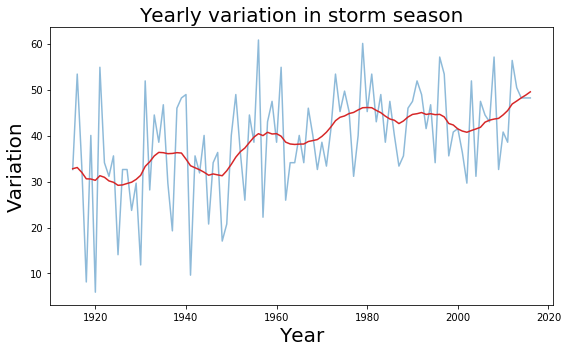

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['mad'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')                  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

The figure below displays the estimates of slopes $\hat{\nu}_t$ across time as the solid blue line, and the $50\%$ and $95\%$ posterior credible intervals in dashed blue lines.  The original data, centered at 0 to allow a comparison to the slope estimates, appears in faded red.

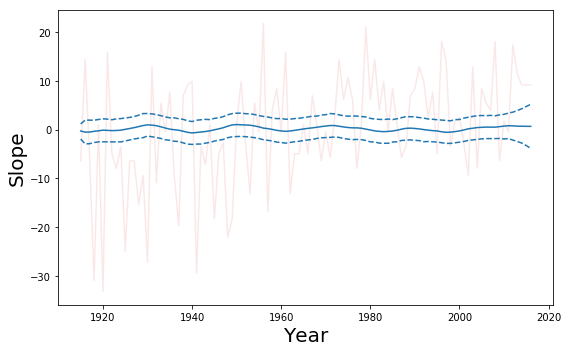

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'] - sdf['mad'].mean(), color='tab:red', alpha=0.1)
bp.curve(sdf['year'], np.percentile(posterior['v'],  [2.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], np.percentile(posterior['v'], [97.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], posterior['v'].mean(axis=0))
plt.xlabel('Year', fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.tight_layout()

Once we account for the correlation across time, it becomes clear that there is no slope estimate that is very large.  This suggests that depsite the fact that the number of storms is going up over time, the season is not significantly being stretched.

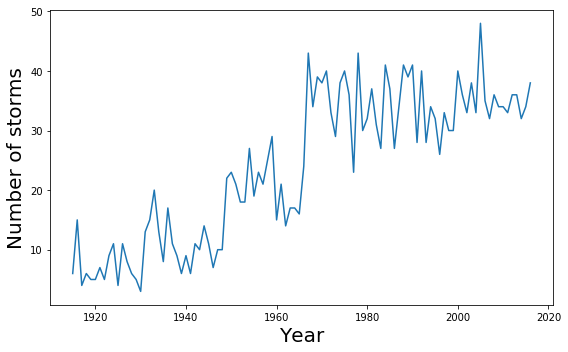

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], df['date'].dt.year.value_counts().sort_index())
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of storms', fontsize=20)
plt.tight_layout()

In [20]:
print(np.any(np.percentile(posterior['v'], [5], axis=0) > 0))
print(np.any(np.percentile(posterior['v'], [95], axis=0) < 0))

False
False


## Proportion of Storms Outside Official Storm Season Increasing?

In [21]:
def outside_SS(df):
    y = df['year'].values[0]
    early = np.sum(df['date'] < datetime.datetime(y, 6, 1))
    late = np.sum(df['date'] > datetime.datetime(y, 10, 30))
    n = df['year'].shape[0]
    return (early + late) / n

sdf['prop'] = df.groupby('year', as_index=False).apply(outside_SS)

In [22]:
sdf.to_csv('yearly_data.csv')

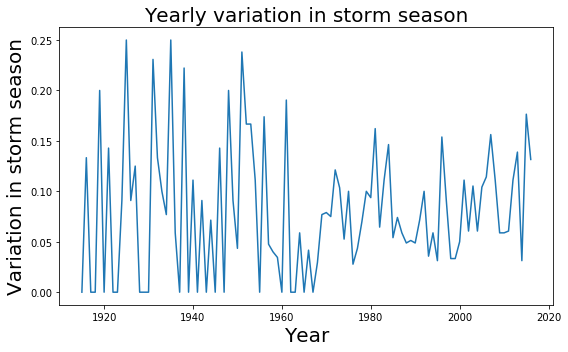

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['prop'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

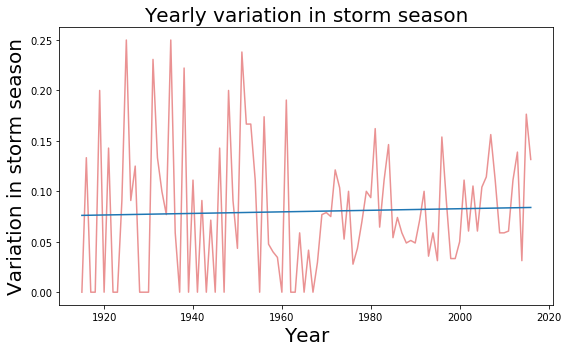

In [67]:
reg = sm.OLS(sdf['prop'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['prop'], color='tab:red', alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [35]:
#local_linear = requests.get('https://raw.githubusercontent.com/roualdes/stormevents/master/local_linear.stan').text
with open('/Users/ez/stormevents/local_linear_trend.stan', 'r') as ll:
    beta_linear = ll.read()
print(beta_linear)

data {
  int<lower=1> T;
  vector<lower=0, upper=1>[T] y;
}
parameters {
  vector[T] u_err;
  real<lower=0> u_tau;
  vector[T] v_err;
  real<lower=0> phi;                // dispersion parameter
}
transformed parameters{
  vector[T] u;
  vector[T] v;
  vector[T] mu;
  vector[T] alpha; 
  vector[T] beta;

  u[1] = y[1] + u_tau * u_err[1];
  v[1] = v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + u_tau * u_err[t-1];
    v[t] = v[t-1] + v_err[t-1];
    mu[t] = inv_logit(u[t]);
  }

  alpha = mu * phi;
  beta = (1.0 - mu) * phi;
}
model {
  // priors
  v_err ~ normal(0, 1);
  u_err ~ normal(0, 1);
  u_tau ~ normal(0, 2.5);
  phi ~ normal(0, 2.5);
  
  // likelihood
  y ~ beta(alpha, beta);
}
generated quantities {
  vector[T] y_pred;
  for (t in 1:T)
    y_pred[t] = beta_rng(alpha[t], beta[t]);
}



In [36]:
st_beta_mod = pystan.StanModel(model_code=beta_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_06868a7f1e4921b2299f5e34ba7825ea NOW.


In [ ]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': sdf['prop'],                                                 
}
stfit = stmod.sampling(data=sdata, control={'max_treedepth': 20})                                                                                                                                    
posterior = stfit.extract() 

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [ ]:
stan_utility.check_treedepth(stfit, max_depth=20)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['mad'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')                  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'] - sdf['mad'].mean(), color='tab:red', alpha=0.1)
bp.curve(sdf['year'], np.percentile(posterior['v'],  [2.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], np.percentile(posterior['v'], [97.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], posterior['v'].mean(axis=0))
plt.xlabel('Year', fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.tight_layout()

## Stationary Distribution?

In [44]:
hist, bins = np.histogram(df['cnum_dates'], bins=df['cnum_dates'].nunique(), density=True)

In [45]:
cdf = np.cumsum(hist)
ecdf = cdf/cdf[-1]

In [46]:
ks = []
for year in np.nditer(df['date'].dt.year.unique()):
    h, _ = np.histogram(df['cnum_dates'][df['date'].dt.year == year], bins=df['cnum_dates'].nunique(), density=True)
    bcdf = np.cumsum(h)
    ks.append(np.max(np.abs(ecdf - bcdf/bcdf[-1])))
KS = np.array(ks)

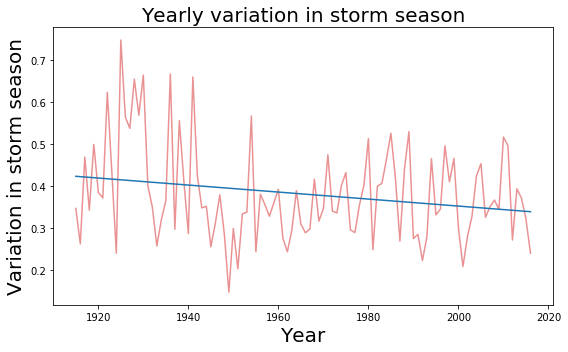

In [47]:
reg = sm.OLS(KS, sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], KS, color='tab:red', alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [14]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.830
Date:                Thu, 07 Jun 2018   Prob (F-statistic):             0.0303
Time:                        15:15:43   Log-Likelihood:                 78.938
No. Observations:                 102   AIC:                            -153.9
Df Residuals:                     100   BIC:                            -148.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0187      0.745      2.709      0.0

In [49]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': KS,                                                 
}
stfit = stmod.sampling(data=sdata, control={'max_treedepth': 20})                                                                                                                                    
posterior = stfit.extract()  

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


KeyboardInterrupt: 

In [21]:
stan_utility.check_treedepth(stfit, max_depth=20)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)

0 of 4000 iterations saturated the maximum tree depth of 20 (0.0%)
Chain 1: E-BFMI = 0.15412947715099715
Chain 3: E-BFMI = 0.11753193730677881
  E-BFMI below 0.2 indicates you may need to reparameterize your model
412.0 of 4000 iterations ended with a divergence (10.3%)
  Try running with larger adapt_delta to remove the divergences


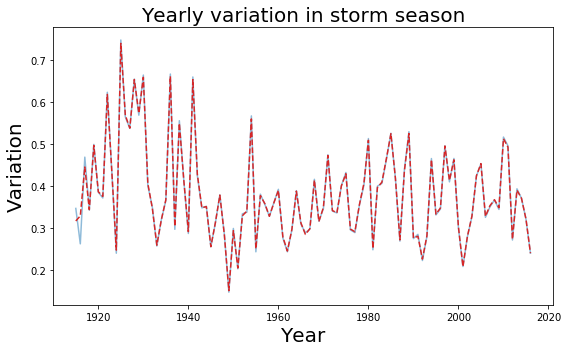

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], KS, alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red', linestyle='--')  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

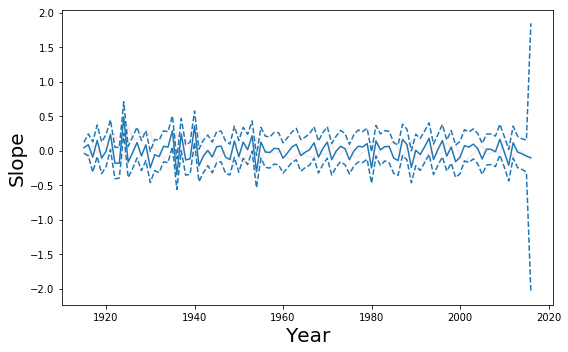

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], KS - KS.mean(), color='tab:red', alpha=0.1)
bp.curve(sdf['year'], np.percentile(posterior['v'],  [2.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], np.percentile(posterior['v'], [97.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], posterior['v'].mean(axis=0))
plt.xlabel('Year', fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.tight_layout()

In [36]:
posterior['y_err'].mean()

0.05961377754954965